# Aztec G-dDT Test Run

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import os
import plotly.express as px
import seaborn as sns 
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = "png"

## Perform Simulation

In [2]:
from aztec_gddt.experiment import test_run
from aztec_gddt.scenario_experiments import scenario_group_1_experiment

exp = scenario_group_1_experiment()


from cadCAD.engine import ExecutionContext, ExecutionMode, Executor


_exec_mode = ExecutionMode().single_mode
exec_context = ExecutionContext(_exec_mode, additional_objs={'deepcopy_off': True})
executor = Executor(exec_context=exec_context, configs=exp.configs, supress_print=False)

# Execute the cadCAD experiment
(records, tensor_field, _) = executor.execute()

# Parse the output as a pandas DataFrame
df = pd.DataFrame(records)

# Drop substeps
first_ind = (df.substep == 0) & (df.timestep == 0)
last_ind = df.substep == max(df.substep)
inds_to_drop = first_ind | last_ind
df = df.loc[inds_to_drop].drop(columns=['substep'])


# Assign Params
M_dict = exp.configs[0].sim_config['M']
params_set = set(M_dict.keys())

selected_params = params_set
# Attribute parameters to each row*

from cadCAD.tools.execution.easy_run import select_config_M_dict # type: ignore
params_dict = select_config_M_dict(exp.configs, 0, selected_params)

# Handles all cases of parameter types including list
for key, value in params_dict.items():
    df[key] = df.apply(lambda _: value, axis=1)

for i, (_, n_df) in enumerate(df.groupby(['simulation', 'subset', 'run'])):
    params_dict = select_config_M_dict(exp.configs, i, selected_params)
    for key, value in params_dict.items():
        df.loc[n_df.index, key] = df.loc[n_df.index].apply(
            lambda _: value, axis=1)
        

sim_df = df


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.3
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (2, 200, 88, 300, 32)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 44, 155, 32)
     Simulation 1: (Timesteps, Params, Runs, Sub-States) = (100, 44, 145, 32)


Initializing configurations:   0%|          | 0/300 [00:00<?, ?it/s]

Execution Method: single_proc_exec


Flattening results:   0%|          | 0/180300 [00:00<?, ?it/s]

Total execution time: 11.09s


## Visualization over Model Features

In [3]:
sim_df.head(5)

,timestep,l1_blocks_passed,delta_l1_blocks,l2_blocks_passed,agents,validator_set,current_epoch,last_epoch,last_reward_time_in_l1,last_reward,...,ORACLE_UPDATE_FREQUENCY_E,JUICE_PER_WEI_MEAN,JUICE_PER_WEI_STD,MAX_FEE_INFLATION_PER_BLOCK,MAX_FEE_INFLATION_RELATIVE_MEAN,MAX_FEE_INFLATION_RELATIVE_STD,JUICE_PER_MANA_MEAN,JUICE_PER_MANA_STD,PROVING_COST_MODIFIER_INITIAL_C,FEE_JUICE_PRICE_MODIFIER_INITIAL_C
0,0,0,0,0,"[Agent(uuid='0', commitment_bond=2.81777570011...",{},"Epoch(init_time_in_l1=-999, validators=[], slo...","Epoch(init_time_in_l1=-999, validators=[], slo...",0,15000.0,...,0.5,5.0,2.0,0.1,0.5,0.3,10.0,10.0,1000,1.0
6,1,1,1,1,"[Agent(uuid='0', commitment_bond=2.81777570011...",{},"Epoch(init_time_in_l1=1, validators=['290', '4...","Epoch(init_time_in_l1=-999, validators=[], slo...",0,15000.0,...,0.5,5.0,2.0,0.1,0.5,0.3,10.0,10.0,1000,1.0
12,2,2,1,1,"[Agent(uuid='0', commitment_bond=2.81777570011...",{},"Epoch(init_time_in_l1=1, validators=['290', '4...","Epoch(init_time_in_l1=-999, validators=[], slo...",0,15000.0,...,0.5,5.0,2.0,0.1,0.5,0.3,10.0,10.0,1000,1.0
18,3,3,1,1,"[Agent(uuid='0', commitment_bond=2.81777570011...",{},"Epoch(init_time_in_l1=1, validators=['290', '4...","Epoch(init_time_in_l1=-999, validators=[], slo...",0,15000.0,...,0.5,5.0,2.0,0.1,0.5,0.3,10.0,10.0,1000,1.0
24,4,4,1,2,"[Agent(uuid='0', commitment_bond=2.81777570011...",{},"Epoch(init_time_in_l1=1, validators=['290', '4...","Epoch(init_time_in_l1=-999, validators=[], slo...",0,15000.0,...,0.5,5.0,2.0,0.1,0.5,0.3,10.0,10.0,1000,1.0


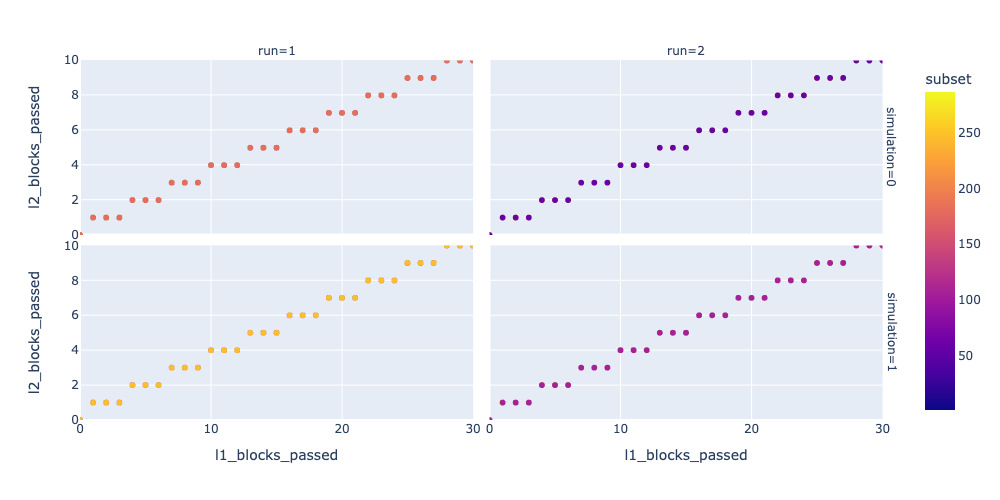

In [4]:
fig = px.scatter(sim_df.reset_index(), x='l1_blocks_passed', y='l2_blocks_passed', color='subset', facet_col='run', facet_row='simulation')
fig.update_layout(yaxis_range=[0, 10], xaxis_range=[0,  10 * 3], width=1000, height=500)
fig.show()

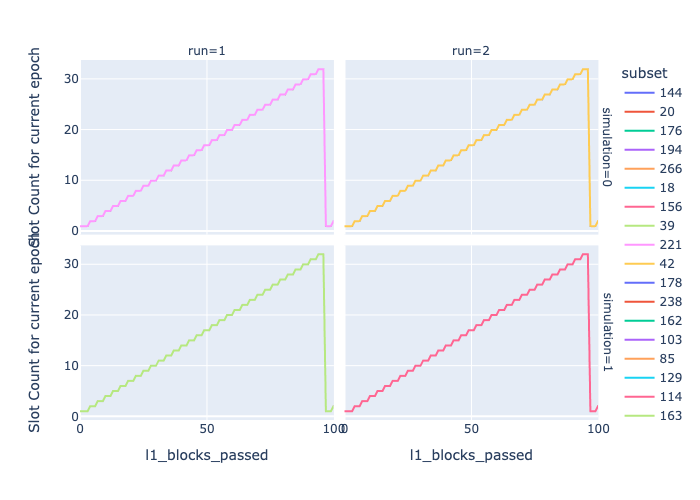

In [5]:
y = sim_df.current_epoch.map(lambda x: len(x.slots))

fig = px.line(sim_df, x='l1_blocks_passed', y=y, labels={"x": 'timestep', 'y': 'Slot Count for current epoch'}, color='subset', facet_col='run', facet_row='simulation')
fig.show()

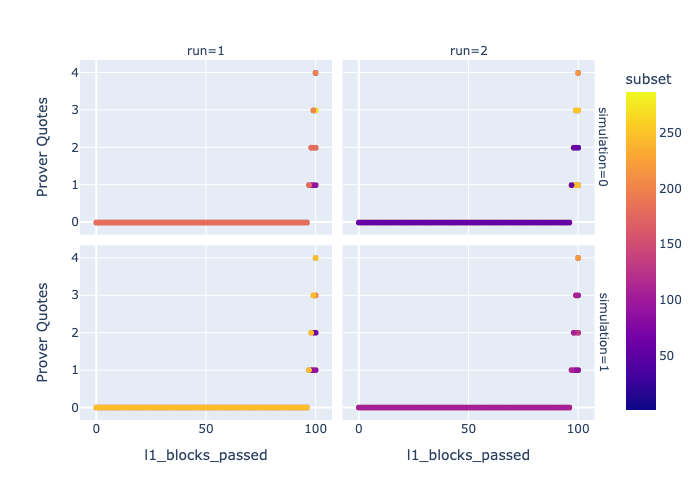

In [6]:
y = sim_df.last_epoch.map(lambda x: len(x.prover_quotes))

fig = px.scatter(sim_df, x='l1_blocks_passed', y=y, labels={"x": 'timestep', 'y': 'Prover Quotes'}, color='subset', facet_col='run', facet_row='simulation')
fig.show()

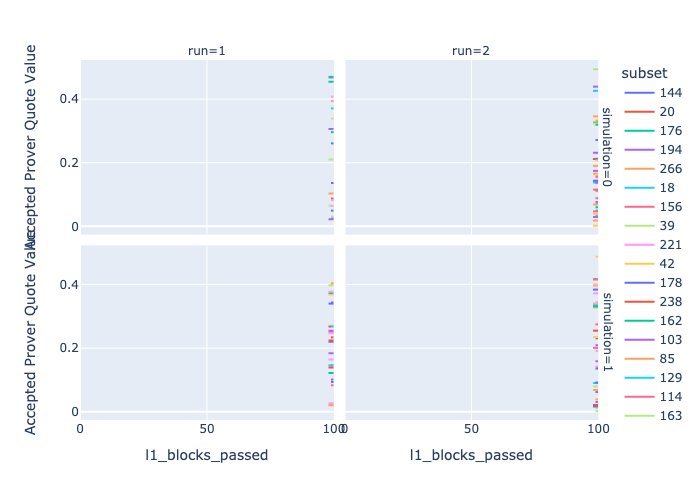

In [7]:
y = sim_df.last_epoch.map(lambda x: x.accepted_prover_quote)

fig = px.line(sim_df, x='l1_blocks_passed', y=y, labels={"x": 'timestep', 'y': 'Accepted Prover Quote Value'}, color='subset', facet_col='run', facet_row='simulation')
fig.show()

## Visualization over PSUU Per-Trajectory Metrics

In [8]:
from aztec_gddt.psuu.metrics import *


RELEVANT_PER_TRAJECTORY_METRICS = ['T-M1', 'T-M2', 'T-M3']
RELEVANT_PER_TRAJECTORY_GROUP_METRICS = ['TG-M1', 'TG-M2', 'TG-M3']

In [9]:
for label in RELEVANT_PER_TRAJECTORY_METRICS:
    fn = PER_TRAJECTORY_METRICS[label]
    print(f"{label}: {fn.__name__}")
    print(sim_df.reset_index().groupby(['simulation', 'subset', 'run']).apply(fn, include_groups=False))
    print("---")

T-M1: relative_volatility_across_time
simulation  subset  run
0           5       2      0.011600
            8       1      0.025754
            9       1      0.016034
                    2      0.006562
            10      1      0.016102
                             ...   
1           280     2      0.025995
            281     2      0.026324
            283     1      0.017176
            284     1      0.002099
            286     2      0.010471
Length: 300, dtype: float64
---
T-M2: empty_blocks_during_trajectory
simulation  subset  run
0           5       2      1
            8       1      1
            9       1      1
                    2      1
            10      1      1
                          ..
1           280     2      1
            281     2      1
            283     1      1
            284     1      1
            286     2      1
Length: 300, dtype: int64
---
T-M3: unproven_epochs_during_trajectory
simulation  subset  run
0           5       2      1
       

In [10]:
for label in RELEVANT_PER_TRAJECTORY_GROUP_METRICS:
    fn = PER_TRAJECTORY_GROUP_METRICS[label]

    groups = list(sim_df.reset_index().groupby(['simulation']))
    for i, g in groups:
        dfs = [el[1] for el in list(g.groupby('run'))]
        print(f"{label}: {fn.__name__}")
        print(fn(dfs))
        print("---")    

TG-M1: <lambda>
0.001983577311072439
---
TG-M1: <lambda>
0.0036012611461481558
---
TG-M2: <lambda>
1.0
---
TG-M2: <lambda>
1.0
---
TG-M3: <lambda>
1.0
---
TG-M3: <lambda>
1.0
---


In [11]:
control_params = [
        'RELATIVE_TARGET_MANA_PER_BLOCK',
        'MAXIMUM_MANA_PER_BLOCK',
        'MINIMUM_MULTIPLIER_CONGESTION',
        'UPDATE_FRACTION_CONGESTION',
        'OVERHEAD_MANA_PER_TX',
        'PROVING_COST_MODIFIER_INITIAL_C',
        'FEE_JUICE_PRICE_MODIFIER_INITIAL_C',
        'MAXIMUM_UPDATE_PERCENTAGE_C',
        ]

In [12]:
group_params = ['simulation', 'subset'] + control_params


records = []

for label in RELEVANT_PER_TRAJECTORY_GROUP_METRICS:
    fn = PER_TRAJECTORY_GROUP_METRICS[label]

    groups = list(sim_df.reset_index().groupby(group_params))
    for i, g in groups:
        dfs = [el[1] for el in list(g.groupby('run'))]
        value = fn(dfs)
        record = dict(zip(group_params, i))
        record['metric'] = label
        record['metric_value'] = value
        records.append(record)


In [38]:
agg_df = pd.DataFrame(records).groupby(group_params + ['metric']).metric_value.first().unstack().reset_index()
agg_df['TG-aM1'] = agg_df['TG-M1'] < agg_df['TG-M1'].median()

In [39]:
from aztec_gddt.psuu.metrics import *


# for control_param in control_params:
#     print(f"### {control_param} ###")
#     groups = list(sim_df.reset_index().groupby([control_param]))

#     for i, g in groups:
#         print(f"{control_param} = {i}")
#         for label, fn in PER_TRAJECTORY_GROUP_METRICS.items():
#             dfs = [el[1] for el in list(g.groupby(['simulation', 'subset', 'run']))]
#             print(f"{label}={fn(dfs) :.3f}")
#         print("---")

In [40]:
text = f"""
#### Computational Complexity:
1. Total number of parameter combinations: {len(sim_df.subset.unique()):,}
2. Total number of Monte Carlo runs per parameter combination: {len(sim_df.run.unique()):,}
3. Total number of trajectories: {len(sim_df[['subset', 'run']].drop_duplicates()):,}
4. Total number of timesteps per trajectory: {sim_df.timestep.max():,}
5. Total number of state measurements: {len(sim_df):,}
"""

print(text)


#### Computational Complexity:
1. Total number of parameter combinations: 200
2. Total number of Monte Carlo runs per parameter combination: 2
3. Total number of trajectories: 261
4. Total number of timesteps per trajectory: 100
5. Total number of state measurements: 30,300



### Adaptive Grid Results

### Protocol Parameter Recommendations 


| Control Parameter | Recommended Range | Unit |
| - | - | - |
| RELATIVE_TARGET_MANA_PER_BLOCK | tbd | Mana |
| MAXIMUM_MANA_PER_BLOCK | tbd | Mana |
| MINIMUM_MULTIPLIER_CONGESTION | tbd | Unitless |
| UPDATE_FRACTION_CONGESTION | tbd | 1 / Mana |
| OVERHEAD_MANA_PER_TX | tbd | Mana |
| PROVING_COST_MODIFIER_INITIAL_C | tbd | Mana |
| FEE_JUICE_PRICE_MODIFIER_INITIAL_C | tbd | Juice per Wei |
| MAXIMUM_UPDATE_PERCENTAGE_C | tbd | Unitless |

### Decision Tree and Parameter Importance

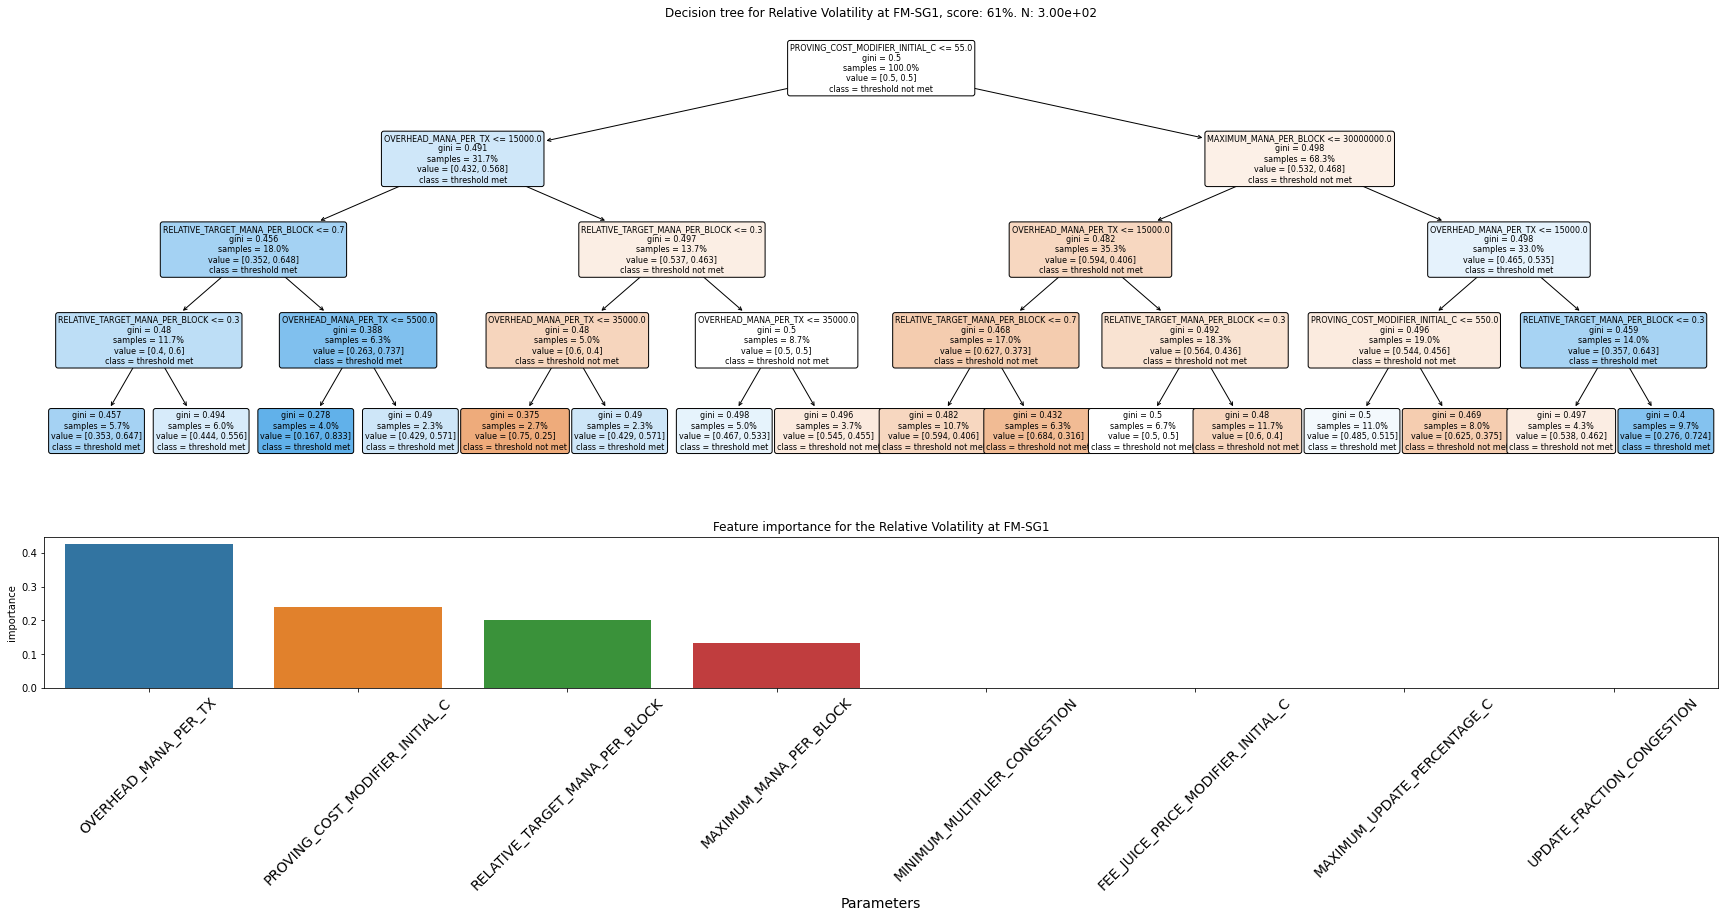

In [41]:
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def fit_predict(X: pd.DataFrame,
      y: pd.Series,
      target: str,
      ax_dt: object,
      ax_rf: object,
      label: str = 'target',
      font_size: int = 12):
    """
    Fit DT and RF classifiers for summarizing the sensivity.
    """
    model = DecisionTreeClassifier(class_weight='balanced',
                                   max_depth=4,
                                   )
    rf = RandomForestClassifier()
    model.fit(X, y)
    rf.fit(X, y)


    df = (pd.DataFrame(list(zip(X.columns, rf.feature_importances_)),
                        columns=['features', 'importance'])
            .sort_values(by='importance', ascending=False)
            )

    plot_tree(model,
                rounded=True,
                proportion=True,
                fontsize=font_size,
                feature_names=list(X.columns),
                class_names=['threshold not met', 'threshold met'],
                filled=True,
                ax=ax_dt)
    ax_dt.set_title(
        f'Decision tree for {label}, score: {model.score(X, y) :.0%}. N: {len(X) :.2e}')
    sns.barplot(data=df,
                x=df.features,
                y=df.importance,
                ax=ax_rf,
                label='small')
    plt.setp(ax_rf.xaxis.get_majorticklabels(), rotation=45)
    ax_rf.tick_params(axis='x', labelsize=14)
    ax_rf.set_xlabel("Parameters", fontsize=14)
    ax_rf.set_title(f'Feature importance for the {label}')
    
    return df.assign(target=target)



def param_sensitivity_plot(df: pd.DataFrame,
                           control_params: set,
                           target: str,
                           label: str = 'target',
                           height: int = 12,
                           width: int = 30,
                           font_size: int = 8):
    """
    Plot the sensivity of the 'target' column vs
    a list of control parameters, which are data frame columns.
    """
    
    features = set(control_params) - {target}
    X = df.loc[:, list(features)]
    y = (df[target] > 0)
    # Visualize
    fig, axes = plt.subplots(nrows=2,
                             figsize=(width, height),
                             dpi=72,
                             gridspec_kw={'height_ratios': [3, 1]})
    fit_predict(X, y, 'target', axes[0], axes[1], label, font_size)

    return None


param_sensitivity_plot(agg_df, control_params, 'TG-aM1', label='Relative Volatility at FM-SG1')

In [22]:
y

0      True
1      True
2      True
3      True
4      True
       ... 
295    True
296    True
297    True
298    True
299    True
Name: TG-M1, Length: 300, dtype: bool

### Commentary on Results:
